# Crop and Rotation of spatial transcriptomic data

Spatial transcriptomics technologies such as Visium from 10x Genomics allow us to understand gene expression in the context of tissue architecture. However, we often need to preprocess and manipulate the spatial data to focus on regions of interest or to align the data properly for analysis.

In this tutorial, we demonstrate how to:
1. Load spatial transcriptomics data
2. Visualize the spatial distribution of spots
3. Crop a specific region of interest
4. Rotate the spatial data for better alignment
5. Manually adjust the spatial mapping

This tutorial uses the breast cancer sample from 10x Genomics' Visium platform as an example. 

In [1]:
import scanpy as sc
#import pertpy as pt
import omicverse as ov
ov.plot_set()

🔬 Starting plot initialization...
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA H100 80GB HBM3
    • Total memory: 79.1 GB
    • Compute capability: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.0   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Loading the Spatial Data

We start by importing the necessary libraries and loading a sample Visium dataset from the breast cancer dataset available through the Scanpy package. This dataset contains spatial gene expression data from a breast cancer tissue section. 

In [2]:
adata=sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")
adata

  0%|          | 0.00/9.50M [00:00<?, ?B/s]

  0%|          | 0.00/26.9M [00:00<?, ?B/s]

reading /scratch/users/steorra/analysis/omic_test/data/V1_Breast_Cancer_Block_A_Section_1/filtered_feature_bc_matrix.h5
 (0:00:00)


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Visualizing the Spatial Data

We first visualize the original spatial data to get an overview of the tissue section. The `sc.pl.spatial()` function displays the tissue image with spots overlaid, giving us a sense of the tissue structure and spot distribution. This helps us identify regions of interest for further analysis. 

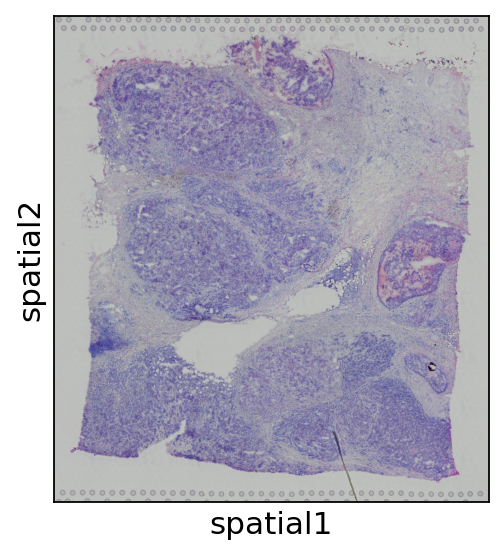

In [3]:
sc.pl.spatial(
    adata,
    color=None
)

## Understanding Spatial Coordinates

Below we demonstrate how to access and visualize the spatial coordinates of the spots. Visium data contains spatial information in the `obsm['spatial']` attribute of the AnnData object, which needs to be properly scaled using scaling factors stored in the `uns['spatial']` attribute.

The scaling factor `tissue_hires_scalef` is used to align the spot coordinates with the high-resolution tissue image. This visualization helps us understand the coordinate system before we apply any transformations. 

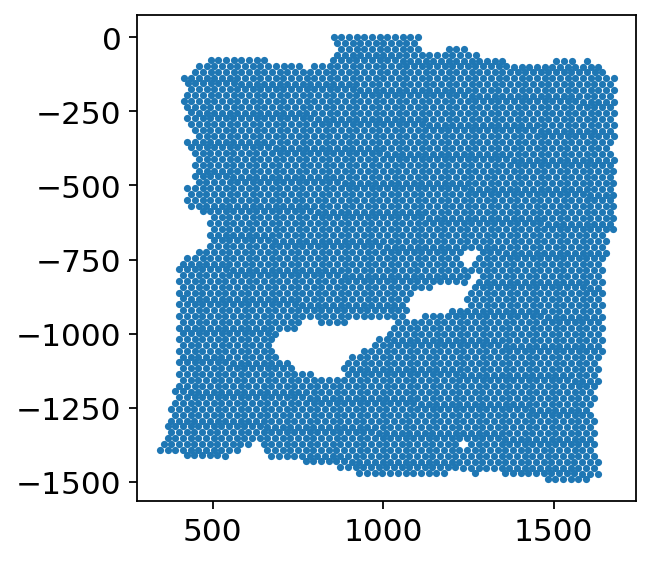

In [37]:
library_id=list(adata.uns['spatial'].keys())[0]
res='hires'
fig, ax = ov.plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(
    adata.obsm['spatial'][:,0]*adata.uns['spatial'][library_id]['scalefactors'][f'tissue_{res}_scalef'],
    (adata.obsm['spatial'][:,1].min()-adata.obsm['spatial'][:,1])*adata.uns['spatial'][library_id]['scalefactors'][f'tissue_{res}_scalef'],
    s=5
)
ax.grid(False)


## Cropping the Spatial Data

Often, we need to focus on a specific region of interest within the tissue. The `crop_space_visium` function allows us to select a rectangular area defined by:
- `crop_loc`: The top-left corner coordinates (x, y) of the cropping area
- `crop_area`: The width and height of the cropping area
- `library_id`: The identifier for the spatial data
- `scale`: A scaling factor for the cropping coordinates

This operation creates a new AnnData object containing only the spots within the specified region, along with the corresponding portion of the tissue image. 

In [33]:
adata_sp = ov.space.crop_space_visium(
    adata, 
    crop_loc=(0, 0),      
    crop_area=(1000, 1000), 
    library_id=list(adata.uns['spatial'].keys())[0] , 
    scale=1
)

Adding image layer `image`


## Visualizing the Cropped Data

After cropping, we visualize the result to confirm that we've selected the correct region of interest. This helps us verify that the cropping operation was successful and that we've captured the area we want to analyze. 

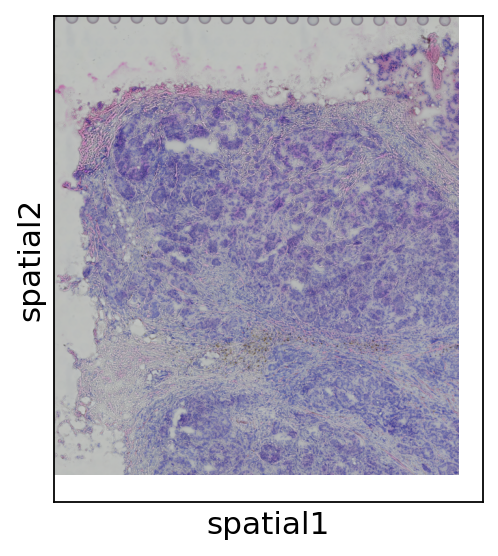

In [34]:
sc.pl.spatial(
    adata_sp,
    color=None
)

## Rotating the Spatial Data

Sometimes the tissue orientation may not be optimal for analysis. The `rotate_space_visium` function allows us to rotate the spatial data and associated image by a specified angle:
- `angle`: The rotation angle in degrees (positive for counterclockwise rotation)
- `center`: The center point for rotation (if None, uses the center of the image)
- `library_id`: The identifier for the spatial data
- `interpolation_order`: The order of interpolation for the image transformation

After rotation, we need to map the spatial coordinates using `map_spatial_auto` to ensure proper alignment between the spots and the tissue image. The 'phase' method uses phase correlation to automatically find the best alignment. 

In [ ]:
library_id = list(adata.uns['spatial'].keys())[0]
# 
angle = 45  # rotation angle
center = None # Center of rotation, None means use the center of image/spatial coordinates
interpolation_order = 1 # Interpolation order (bilinear interpolation)
adata.obs['Anno_manual']='1'
adata_rotated = ov.space.rotate_space_visium(
    adata, 
    angle, 
    center, 
    library_id=library_id, 
    interpolation_order=interpolation_order
)
adata_rotated.obsm['spatial']=adata_rotated.obsm['spatial'].astype(ov.np.float64)
ov.space.map_spatial_auto(
    adata_rotated,
    method='phase'
)

## Visualizing the Rotated Data

After rotation, we need to visualize the result to verify that the rotation was applied correctly. Here we overlay the rotated spots on the rotated tissue image. We use the `sc.pl.embedding` function which allows more customization of the plot than `sc.pl.spatial`.

We can adjust the coordinates and alpha blending to optimize the visualization of the spots and tissue image together. 

(2133.19469825, 101.78877775000001)

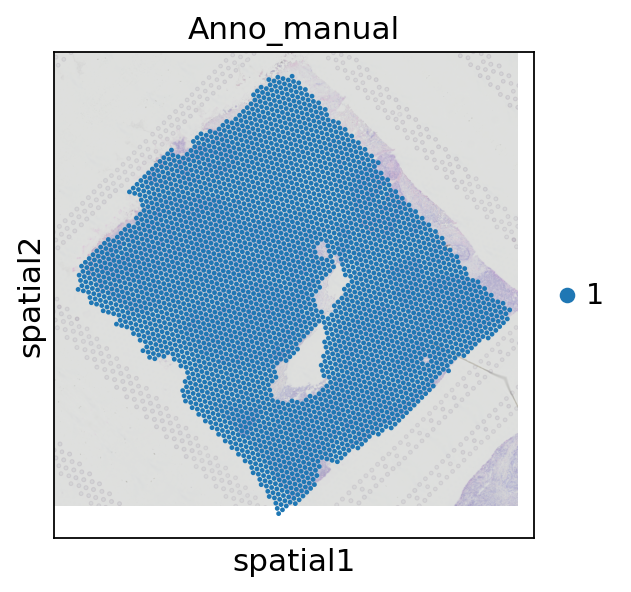

In [55]:
library_id = list(adata_rotated.uns['spatial'].keys())[0]
scalefactors = adata_rotated.uns['spatial'][library_id]['scalefactors']
tissue_hires_scalef = scalefactors['tissue_hires_scalef']
ax=sc.pl.embedding(
    adata_rotated,
    basis='spatial',
    color='Anno_manual',
    size=10,
    scale_factor=tissue_hires_scalef,
    show=False,
)
img=adata_rotated.uns["spatial"][library_id]["images"]["hires"]
cur_coords = ov.np.concatenate([ax.get_xlim(), ax.get_ylim()])
#ax.set_xlim(cur_coords[0], cur_coords[1])
ax.imshow(img, cmap='gray', alpha=0.5)
ax.set_xlim(cur_coords[0], cur_coords[1])
ax.set_ylim(cur_coords[3], cur_coords[2])

## Manual Adjustment of Spatial Mapping

Sometimes automatic mapping isn't perfect, and we need to manually adjust the alignment between spots and the tissue image. The `map_spatial_manual` function allows us to apply a manual offset:
- `offset`: The (x, y) offset to apply to the spatial coordinates

This creates a new spatial coordinate system in `obsm['spatial1']` that we can use for visualization and analysis. Manual adjustments are often necessary to fine-tune the alignment, especially after transformations like rotation. 

(2089.2487421113906, 57.84282161139048)

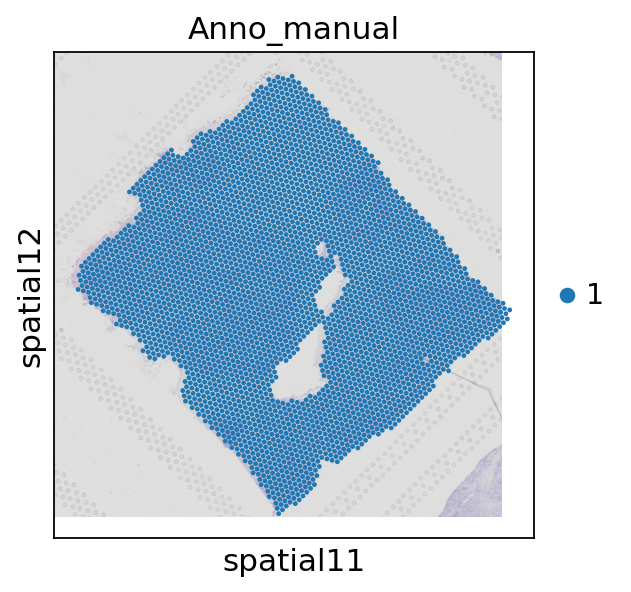

In [66]:
ov.space.map_spatial_manual(adata_rotated,offset=(-1500,1000))

library_id = list(adata_rotated.uns['spatial'].keys())[0]
scalefactors = adata_rotated.uns['spatial'][library_id]['scalefactors']
tissue_hires_scalef = scalefactors['tissue_hires_scalef']
ax=sc.pl.embedding(
    adata_rotated,
    basis='spatial1',
    color='Anno_manual',
    size=10,
    scale_factor=tissue_hires_scalef,
    show=False,
)
img=adata_rotated.uns["spatial"][library_id]["images"]["hires"]
cur_coords = ov.np.concatenate([ax.get_xlim(), ax.get_ylim()])
#ax.set_xlim(cur_coords[0], cur_coords[1])
ax.imshow(img, cmap='gray', alpha=0.5)
ax.set_xlim(cur_coords[0], cur_coords[1])
ax.set_ylim(cur_coords[3], cur_coords[2])